![](../../logo.png)

# Physics Informed Neural Networks (PINNs) from scratch


Eduard Larrañaga (ealarranaga@unal.edu.co)

---



## Example: Exponential decay

An exponential decay of a physical quantity $y(x)$ is described by the ODE

\begin{equation} 
  y'(x) = -\gamma y(x),
\end{equation}


together with the initial condition $y(0) = y_0$, with $y_0$ a constant. In this example we will consider the values $\gamma = 2$ and $y_0 = 10$.

It is well known that the analytical solution of this problem is

\begin{equation}
  y(x) = y_0 \exp\left(-\gamma x\right).
\end{equation}


Since we know the analytical solution, it is possible to use it to compare with the result of the neural network's solution.

## Setup of the Neural Network  and the trial solution

We will create a neural network with the following structure:

- an input layer with $N_{\text{in}}$ (no weights and no bias to optimize)
- a hidden layer with $N_{\text{hid} }$ neurons and $\theta^{\text{hid}}$ parameters to optimize
- an output layer with $N_{\text{out} }$ neurons and $\theta^{\text{out}}$ parameters to optimize.


Hence, we will have  a set of parameters  $\theta = \{ \theta^{\text{hid}},  \theta^{\text{out}} \}$ that will be optimized.

## The trial solution
The trial solution $\hat{y}(t)$ is written as

$$
\hat{y}(x; \theta) = h_0(x) + h_1(x, \mathcal{N}(x; \theta)).
$$

Since the initial condition states that $y(0) = y_0$, we need that $\hat{y}(0; \theta) = y_0$. This is acomplished by choosing $h_0(x) = y_0$ and $h_1(x, \mathcal{N}(x; \theta)) = x \cdot \mathcal{N}(x; \theta)$. Then, we get

\begin{equation}
\hat{y}(x, \theta) = y_0 + x \cdot \mathcal{N}(x, \theta).
\end{equation}


### The Loss Function

The trial solution has been chosen such that it already solves the initial condition $y(0) = y_0$. Now, the neural network must find the set of weights and biases $P$ such that the trial solution satisfies the ODE, i.e. such that


\begin{equation} 
\hat{y}'(x; \theta) = - \gamma \hat{y}(x; \theta),
\end{equation}


is fulfilled as *best as possible*. Therefore, we define the loss function for an input value $x$ as

\begin{equation}
\mathcal{L}(x;\theta ) = \left[ \hat{y}'(x; \theta ) - ( -\gamma \hat{y}(x; \theta ) ) \right]^2
\end{equation}



## Gradient descent

The idea of the gradient descent algorithm is to update the parameters in a direction where the loss function decreases.

In general, the update of the parameters $\theta$ given the loss function goes as

$$
\theta_{\text{new} } = \theta - \alpha \nabla_{\theta} \mathcal{L}(\boldsymbol{x}; \theta)
$$

for a given number of iterations or until $ \big|\big| \theta_{\text{new} } - \theta \big|\big|$ becomes smaller than some given tolerance. The value of $\alpha$ (learning rate) decides how large steps the algorithm must take
in the direction of $ \nabla_{\theta} \mathcal{L}(\boldsymbol{x}; \theta)$.





Note that we will use the library [autograd](https://github.com/HIPS/autograd) for automatic differentiation. A detailed description of this library can be found [here](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2017/tutorials/tut4.pdf) and [here](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_5_Automatic.html)

Initial value of the loss function: 546.055
Epoch: 0 Current loss: 466.504
Epoch: 1000 Current loss: 1.46225
Epoch: 2000 Current loss: 0.641383
Epoch: 3000 Current loss: 0.333367
Epoch: 4000 Current loss: 0.163049
Epoch: 5000 Current loss: 0.093225
Epoch: 6000 Current loss: 0.0631442
Epoch: 7000 Current loss: 0.047072
Epoch: 8000 Current loss: 0.0372212
Epoch: 9000 Current loss: 0.0305668
Epoch: 10000 Current loss: 0.0257277
Epoch: 11000 Current loss: 0.0220088
Epoch: 12000 Current loss: 0.0190344
Epoch: 13000 Current loss: 0.0165883
Epoch: 14000 Current loss: 0.0145387
Epoch: 15000 Current loss: 0.0128005
Epoch: 16000 Current loss: 0.0113153
Epoch: 17000 Current loss: 0.0100407
Epoch: 18000 Current loss: 0.00894411
Epoch: 19000 Current loss: 0.0079993
Final value of the loss function: 0.00718513
Maximum absolute difference between prediction and analytical solution: 0.00921673


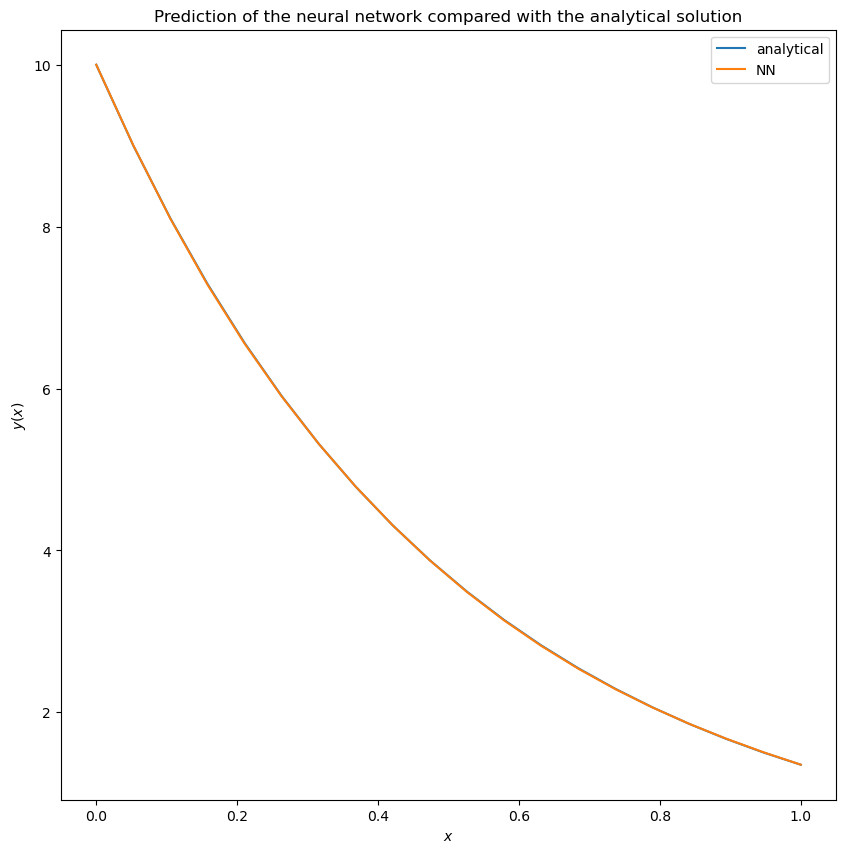

In [6]:
%matplotlib inline
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt


# The activation function
def sigmoid(z):
    return 1/(1 + np.exp(-z))


def neural_network(params, x):

    # Find the weights (including and biases) for the hidden and output layer.
    # Assume that params is a list of parameters for each layer.
    # The biases are the first element for each array in params,
    # and the weights are the remaning elements in each array in params.

    P_hidden = params[0]
    P_output = params[1]

    # Input x is a one-dimensional array
    num_values = np.size(x)
    x_input = x.reshape(-1, num_values)

    ## Hidden layer:
    x_input = np.concatenate((np.ones((1,num_values)), x_input ), axis = 0)

    z_hidden = np.matmul(P_hidden, x_input)
    x_hidden = sigmoid(z_hidden)


    ## Output layer:
    x_hidden = np.concatenate((np.ones((1,num_values)), x_hidden ), axis = 0)

    z_output = np.matmul(P_output, x_hidden)
    x_output = z_output # No activation function

    return x_output


# The trial solution using the deep neural network:
def y_trial(x,params, y0 = 10):
    return y0 + x*neural_network(params,x)


# The right side of the ODE:
def y(x, y_trial, gamma = 2):
    return -gamma*y_trial


# The loss function:
def loss_function(P, x):

    # Evaluate the trial function with the current parameters P
    y_t = y_trial(x,P)

    # Find the derivative w.r.t x of the neural network
    #d_net_out = elementwise_grad(neural_network,1)(P,x)

    # Find the derivative w.r.t x of the trial function
    d_y_t = elementwise_grad(y_trial,0)(x,P)

    # The right side of the ODE
    func = y(x, y_t)

    err_sqr = (d_y_t - func)**2
    loss_sum = np.sum(err_sqr)

    return loss_sum / np.size(err_sqr)



# Solve the exponential decay ODE using neural network with one input, hidden, and output layer
def solve_ode_neural_network(x, num_neurons_hidden, num_iter, lmb):
    ## Set up initial weights and biases
    # For the hidden layer
    p0 = npr.randn(num_neurons_hidden, 2 )
    # For the output layer
    p1 = npr.randn(1, num_neurons_hidden + 1 ) # +1 since bias is included
    P = [p0, p1]

    print('Initial value of the loss function: %g'%loss_function(P, x))

    ## Start finding the optimal weights using gradient descent

    # Find the Python function that represents the gradient of the loss function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    loss_function_grad = grad(loss_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        loss_grad =  loss_function_grad(P, x)

        P[0] = P[0] - 10*lmb * loss_grad[0]
        P[1] = P[1] - lmb * loss_grad[1]

        if i%1000 == 0:
            print('Epoch: %g ' %i, ' Current loss: %g'%loss_function(P,x))
    print('Final value of the loss function: %g'%loss_function(P, x))

    return P


def y_analytic(x, gamma = 2, y0 = 10):
    return y0*np.exp(-gamma*x)



# Solve the given problem
if __name__ == '__main__':
    # Set seed such that the weight are initialized
    # with same weights and biases for every run.
    npr.seed(413)

    ## Decide the vales of arguments to the function to solve
    N = 20
    x = np.linspace(0, 1, N)

    ## Set up the initial parameters
    num_hidden_neurons = 10
    num_iter = 20000
    lmb = 0.001

    # Use the network
    P = solve_ode_neural_network(x, num_hidden_neurons, num_iter, lmb)

    # Print the deviation from the trial solution and true solution
    res = y_trial(x,P)
    res_analytical = y_analytic(x)

    print('Maximum absolute difference between prediction and analytical solution: %g'%np.max(np.abs(res - res_analytical)))




    # Plot the results
    plt.figure(figsize=(10,10))
    plt.title('Prediction of the neural network compared with the analytical solution')
    plt.plot(x, res_analytical)
    plt.plot(x, res[0,:])
    plt.legend(['analytical','NN'])
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y(x)$')
    plt.show()

In [3]:
# Optimized parameters of the neural network
P

[array([[-1.60630585,  3.85893559],
        [-0.31412244, -1.84342966],
        [ 3.13391299, -2.09078588],
        [ 1.98617564, -3.49033868],
        [ 2.32657399, -3.19306401],
        [ 1.47886808, -5.61219114],
        [ 0.37094785,  1.39946664],
        [-4.24971913, -2.19861062],
        [ 3.69314932, -1.51079161],
        [ 0.73325307, -9.11001958]]),
 array([[-3.50782284,  1.61044491, -0.5572713 , -2.91111609, -2.76744655,
         -2.8367608 , -3.05157595,  0.08488099,  1.94592954, -3.41503574,
         -3.9737954 ]])]